<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Kseniia Terekhova, ODS Slack Kseniia
    
## <center> Tutorial
## <center> A little more info about NumPy

### 1. Introduction/justification

Though NumPy was not denoted as prerequisite for mlcourse.ai, there is no doubt that most participants are familiar with it and have no difficulties in performing common actions. However, pieces of interesting information encountered here and there seem to be worth sharing. No one knows everything, NumPy was not covered in the course in details -  but it is a powerful scientific library that can make many mathematical calculations simpler and nicer.<br>
Links to materials the tutorial is based on can be found in the end of the notebook, in the "References" section. And sure, I'm not going to retell NumPy <a href="https://docs.scipy.org/doc/numpy/user/quickstart.html" target=__blank>quickstart tutorial</a>.

### 2. NumPy performance

It is not only convenient API that makes NumPy so useful for scientific purposes, but also its performance characteristics. Python is not the most quick and memory-economical language. When you are often getting MemoryError while working with large ML datasets it does not look as a minor disadvantage.<br>
Let's first compare amounts of bytes taken by standard Python list and identical NumPy array. 

In [8]:
import sys
import numpy as np

In [9]:
mb = 1024 * 1024

python_list = list(range(0, 1000000))
numpy_array = np.array(range(0, 1000000))

print("Python list size: {0:.3f} MB".format(sys.getsizeof(python_list) / mb))
print("Numpy array size: {0:.3f} MB".format(numpy_array.nbytes / mb, "MB"))
print("ArraySize/ListSize ratio: {0:.2f}".format(numpy_array.nbytes / sys.getsizeof(python_list)))

Python list size: 8.583 MB
Numpy array size: 7.629 MB
ArraySize/ListSize ratio: 0.89


11% of gain is something noticeable. But were Python lists implemented so inefficiently? No, actually, they just were implemented differently.

<center>
<img src="../../img/kseniia_numpy_array_vs_python_list.png" style="width: 600px;" />

While NumPy contains data in a continious area in memory, a Python list stores only pointers to the real data. And yes, not only "list in Python is more than just list" but also "an integer in Python is more than just integer". 

<center>
<img src="../../img/kseniia_cint_vs_pyint.png" style="width: 400px;" />

Such way of storing data incurs additional metadata overhead, but gives more flexibility. There is no problems with having such mixed-type list in Python:

In [5]:
mixed_list = [1, 2, 3, 4.0, 5.0, 'abc', 'def', True, False]

In general, NumPy allows such notation too, but as its datastorage is continious, with equal strides, it has to convert all the data to one type. 

Creating mixed int and string array:

In [11]:
np_array_mixed = np.array([i if i % 2 == 0 else str(i) for i in range(0, 1000000)])
np_array_mixed_size = np_array_mixed.nbytes
print("Mixed numpy array size:", np_array_mixed_size / mb, "MB")

Mixed numpy array size: 80.108642578125 MB


And when storing string only:

In [12]:
np_array_str = np.array([str(i) for i in range(0, 1000000)])
np_array_str_size = np_array_str.nbytes
print("Strings-only numpy array size:", np_array_str_size / mb, "MB")

Strings-only numpy array size: 22.88818359375 MB


What? Half-integer half-string array occupies four times more space than string-only one? In reality, there are no integers in the first array: 

In [14]:
print('String array contains type:', np_array_str.dtype)
print('"Mixed" array contains type:', np_array_mixed.dtype)
print('"Mixed" array elements:"', np_array_mixed[:6])

String array contains type: <U6
"Mixed" array contains type: <U21
"Mixed" array elements:" ['0' '1' '2' '3' '4' '5']


All the elements in the "mixed" array were converted to unicode string. And they were converted in very awkward way: "mixed" elements take more bytes than in string-only array. Not sure how did it work internally, but I can suppose that U21 was selected during int conversion in order to accommodate even large numbers, though string representations of all integers < 1000000 fit into 6-characters string.

That allows to make a conclusion that NumPy was designed for high performance computing over large blocks of same-type numbers. Let's try to compare such computations made with NumPy and with Python intrinsics on the example of calculating reciprocals (1/x) of ten million integers. 

In [15]:
nums_list = list(range(1, 10000000))
numpy_nums = np.array(nums_list)

In [16]:
%%time
reciprocal_list = []
for num in nums_list:
    reciprocal_list.append(1 / num)

CPU times: user 1.31 s, sys: 96.1 ms, total: 1.4 s
Wall time: 1.4 s


Python loops shows as quite slow. Maybe list comprehension are quicker?

In [18]:
%%time
reciprocal_list = [1 / num for num in nums_list]

CPU times: user 608 ms, sys: 120 ms, total: 729 ms
Wall time: 727 ms


A little bit. What about NumPy?

In [20]:
%%time
reciprocal_array = 1 / numpy_nums

CPU times: user 46.6 ms, sys: 58.6 ms, total: 105 ms
Wall time: 103 ms


Much more better!

To be honest, there was a small deceit. The amounts of time spent creating list and array were not measured. They are different:

In [22]:
%%time 
nums_list = list(range(1, 10000000))

CPU times: user 227 ms, sys: 164 ms, total: 391 ms
Wall time: 389 ms


In [23]:
%%time
numpy_nums = np.array(nums_list)

CPU times: user 664 ms, sys: 11.4 ms, total: 675 ms
Wall time: 672 ms


In [24]:
%%time
numpy_nums = np.array(range(1, 10000000))

CPU times: user 1.38 s, sys: 461 ms, total: 1.84 s
Wall time: 1.83 s


Does it mean that there was no gain in reality? No, only that it is better to create NumPy arrays using NumPy initialization functions. Numpy.arange in this case.

In [26]:
%%time
numpy_nums = np.arange(1, 10000000)

CPU times: user 26.7 ms, sys: 56.3 ms, total: 83 ms
Wall time: 78.4 ms


In [27]:
%%time
reciprocal_array = 1 / numpy_nums

CPU times: user 67.4 ms, sys: 52.9 ms, total: 120 ms
Wall time: 118 ms


One more example, slightly more complex. Calculating distances from a point to long sequence of other ones:

In [29]:
%%time
point = [1.0, 1.0]
other_points = list([float(x), x + 1.0] for x in range(10000000))
dists = [((point[0] - op[0])**2 + (point[1] - op[1])**2)**0.5 for op in other_points]

CPU times: user 13.1 s, sys: 571 ms, total: 13.6 s
Wall time: 13.6 s


In [30]:
dists[:10]

[1.0,
 1.0,
 2.23606797749979,
 3.605551275463989,
 5.0,
 6.4031242374328485,
 7.810249675906654,
 9.219544457292887,
 10.63014581273465,
 12.041594578792296]

In [31]:
%%time
np_point = np.ones(2)
np_other_points = np.vstack([np.arange(0.0, 10000000.0), np.arange(1.0, 10000001.0)]).T
np_dists = np.sum((np_point - np_other_points)**2, axis=1)**0.5

CPU times: user 236 ms, sys: 255 ms, total: 491 ms
Wall time: 330 ms


In [12]:
np_dists[:10]

array([ 1.        ,  1.        ,  2.23606798,  3.60555128,  5.        ,
        6.40312424,  7.81024968,  9.21954446, 10.63014581, 12.04159458])

The results are the same, but the performance advantage is significant.

### 3. NumPy matrix broadcasting

<p>One of the things that should be noticed about the example above is that it handles matrixes with different dimensions. The np_point has shape (2,) and np_other_points - (10000000, 2). Nevertheless, element-wise operations are performed with them, producing a matrix with shape (10000000,). That is possible by the virtue of <b><i>matrix broadcasting</i></b> mechanism.</p>
<p>Matrix broadcasting in NumPy is a set of rules that allowes to expand two matrixes with different dimentions to  match shapes of each other, in order to perform element-by-element operations. What is important, this set of rules is a  "virtual" mechanism, that just allows to understand how matrixes will interact. No real expansion and memory allocation is performed.</p>
<p>Its simplest case is summing a matrix with a scalar number, that will be added to each element of the matrix:</p>

In [11]:
M = np.ones((3, 3))
print("M:")
print(M)

scalar = 2
M_added = M + scalar

print()
print("M +", scalar, ":")
print(M_added)

M:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

M + 2 :
[[3. 3. 3.]
 [3. 3. 3.]
 [3. 3. 3.]]


A matrix can be summed with a vector in the similar way:

In [39]:
M = np.ones((3, 3))
print(M)

v = np.array([0, 1, 2])
print()
print(v)

M_added = M + v
print()
print(M_added)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

[0 1 2]

[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]


In a more complex case the both matrixes are broadcasted:

In [43]:
a = np.arange(3)
b = np.arange(3)[:, np.newaxis]

print("a:", a)
print("b:\n", b)

summed = a + b
print("\nSummed:")
print(summed)

a: [0 1 2]
b:
 [[0]
 [1]
 [2]]

Summed:
[[0 1 2]
 [1 2 3]
 [2 3 4]]


The rules of matrix broadcasting are this way:<br>
<b>Rule 1:</b> If the two arrays differ in their number of dimensions, the shape of the one with fewer dimensions is padded with ones on its leading (left) side.<br>
<b>Rule 2:</b> If the shape of the two arrays does not match in any dimension, the array with shape equal to 1 in that dimension is stretched to match the other shape.<br>
<b>Rule 3:</b> If in any dimension the sizes disagree and neither is equal to 1, an error is raised.<br>

So, adding a two-dimensional array to a one-dimensional array is performed this way:

In [48]:
M = np.ones((2, 3))
a = np.arange(3)
print("M:", M.shape)
print(M)
print()
print("a:", a.shape)
print(a)

M: (2, 3)
[[1. 1. 1.]
 [1. 1. 1.]]

a: (3,)
[0 1 2]


The shape of a is pad on the left, as it has fewer dimensions:<br>
    M.shape -> (2, 3)<br>
    a.shape -> (1, 3)<br><br>
The the 1-dimension of a is stretched to match M:<br>
    M.shape -> (2, 3)<br>
    a.shape -> (2, 3)<br>

Now the shapes match and matrixes can be summed:

In [47]:
M + a

array([[1., 2., 3.],
       [1., 2., 3.]])

That's what happens when both arrays need to be broadcasted:

In [49]:
a = np.arange(3).reshape((3, 1))
b = np.arange(3)

print("a:", a.shape)
print(a)
print()
print("b:", b.shape)
print(b)

a: (3, 1)
[[0]
 [1]
 [2]]

b: (3,)
[0 1 2]


The shape of b is pad left with ones:<br>
a.shape -> (3, 1)<br>
b.shape -> (1, 3)<br>
<br>
Then both matrixes has dimension to be expanded:<br>
a.shape -> (3, 3)<br>
b.shape -> (3, 3)<br>
<br>
Then the matrixes can be easily summed:

In [50]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

However, broadcasting is not always possible:

In [32]:
M = np.ones((3, 2))
print("M:", M.shape)
print(M)
print()

a = np.arange(3)
print("a:", a.shape)
print(a)
print()

M: (3, 2)
[[1. 1.]
 [1. 1.]
 [1. 1.]]

a: (3,)
[0 1 2]



M.shape -> (3, 2) <br>
a.shape -> (1, 3) <br>
<br>
M.shape -> (3, 2)<br>
a.shape -> (3, 3)<br>

Matrixes shape does not match, the error is raised when trying to perform operations with them:

In [33]:
M + a

ValueError: operands could not be broadcast together with shapes (3,2) (3,) 

The possible solution in such situation is padding "a" with 1 dimention in the <i>right</i> manually. This way the Rule 1 will be skipped and according to the Rule 2 NumPy will just expand matrix to the needed size: 

In [34]:
a = a[:, np.newaxis]

print("a:", a.shape)
print(a)
print()

a: (3, 1)
[[0]
 [1]
 [2]]



In [35]:
M + a

array([[1., 1.],
       [2., 2.],
       [3., 3.]])

### 3. What is np.newaxis?

In the example in the previous section used a np.newaxis constant was used. What is it? Actually it is None.

In [36]:
np.newaxis is None

True

So, just a convenient alias. The <i>np.newaxis</i> constant is useful when converting a 1D array into a row vector or a column vector, by adding new dimensions from left or right side:

In [46]:
arr = np.arange(3)
arr.shape

(3,)

In [47]:
row_vec = arr[np.newaxis, :]
print(row_vec.shape)
print(row_vec)

(1, 3)
[[0 1 2]]


In [49]:
col_vec = arr[:, np.newaxis]
print(col_vec.shape)
print(col_vec)

(3, 1)
[[0]
 [1]
 [2]]


In fact it is similar to <i>np.reshape(-1, 1)</i> and <i>np.reshape(1, -1)</i> down to minor implementation details. But the np.newaxis allows to stack dimentions using slice syntax, without specifying original shape: 

In [66]:
M = np.ones((5, 5))

In [67]:
M[np.newaxis, :, :, np.newaxis, np.newaxis].shape

(1, 5, 5, 1, 1)

In [68]:
M[np.newaxis, ..., np.newaxis, np.newaxis].shape

(1, 5, 5, 1, 1)

And reshape allows to use -1 only once, requiring to explicitly pass original shape when working with multidimentional arrays:

In [69]:
M.reshape(1, -1, -1, 1, 1 ).shape

ValueError: can only specify one unknown dimension

This will work:

In [71]:
M.reshape(1, *M.shape, 1, 1 ).shape

(1, 5, 5, 1, 1)

but doesn't it look a little bit clumsy?

 Adding several new dimensions is useful in ML when working with, for example, convolutional neural networks. Such frameworks as <b>Pytorch</b> allows to initialize its "Tensors" <a href="https://pytorch.org/docs/master/torch.html#torch.from_numpy">from numpy arrays</a>, but often requires input in the form "minibatch × in_channels × iW" or "minibatch × in_channels × iH × iW" (<a href="https://pytorch.org/docs/master/nn.html#torch-nn-functional" target=__blank>torch.nn.functional</a>). There, minibatch and in_channels can be equal to 1, but they must be  present. 

### 4. A quick note about matrix multiplication

Of course, summing is not the only operation that can be applied to matrixes; a number of arithmetic operations can be used, along with several “universal functions”. The operation that I would like to pay some attention is multiplication, i.e. '*'. As other arithmetic operations, in NumPy it is applied elementwise:

In [10]:
A = np.full((2, 2), 2)
print("A:")
print(A)
print()

B = np.full((2, 2), 3)
print("B:")
print(B)
print()

print("A*B:")
print(A*B)

A:
[[2 2]
 [2 2]]

B:
[[3 3]
 [3 3]]

A*B:
[[6 6]
 [6 6]]


But when speaking about matrix multiplication, especially in linear algebra (and ML) another operation is often implied, the <i>matrix product</i>, that is defined this way (formula from <a href="https://en.wikipedia.org/wiki/Matrix_multiplication#Definition" target=__blank>wikipedia</a>):

$$ A = \begin{pmatrix} a_{11}, a_{12} & \cdots & a_{1m}\\a_{21}, a_{22} & \cdots & a_{2m} \\ \vdots & \ddots & \vdots \\ a_{n1}, a_{n2} & \cdots & a_{nm} \end{pmatrix},  B = \begin{pmatrix} b_{11}, b_{12} & \cdots & b_{1p}\\b_{21}, b_{22} & \cdots & b_{2p} \\ \vdots & \ddots & \vdots \\ b_{m1}, b_{m2} & \cdots & b_{mp} \end{pmatrix} $$
Matrix product <b>C</b> = <b>AB</b>:
$$C = \begin{pmatrix} c_{11}, c_{12} & \cdots & c_{1p} \\c_{21}, c_{22} & \cdots & c_{2p} \\ \vdots & \ddots & \vdots \\ c_{n1}, c_{n2} & \cdots & c_{np} \end{pmatrix} $$ 
$c_{ij} = a_{i1}b_{1j} + ... +  a_{im}b_{mj} = \sum_{k=1}^{m} a_{ik}b_{kj}$

The <i>numpy.dot()</i> function or "@" shortcut is used for this purpose in NumPy. That is unpleasant to confuse these two operations, especially when matrix broadcasting exists:

In [25]:
A = np.arange(1, 10).reshape(3,3)
print("A:")
print(A)
print()

B = np.full((3,), 3)
print("B:")
print(B)
print()

print("A*B:")
print(A*B)

print()
print("A@B:")
print(A@B)

A:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

B:
[3 3 3]

A*B:
[[ 3  6  9]
 [12 15 18]
 [21 24 27]]

A@B:
[18 45 72]


So, be attentive :)

### 5. No mess with np.meshgrid

We used np.meshgrid function somewhere in the course, but without any explanations. That's pity in my opinion, as it is not so easy to grasp what it does from the NumPy <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html" target=__blank>documentation</a>:
<blockquote cite="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html">
numpy.meshgrid(*xi, **kwargs)<br>

Return coordinate matrices from coordinate vectors.<br>

Make N-D coordinate arrays for vectorized evaluations of N-D scalar/vector fields over N-D grids, given one-dimensional coordinate arrays x1, x2,…, xn.
</blockquote>

Nevertheless, the first time I've saw its usage was in the <a href="https://towardsdatascience.com/convnets-series-spatial-transformer-networks-cff47565ae81" target=__blank>article</a> about Spatial Transformer Networks, on the step with "Identity meshgrid" and "Transformed meshgrid". So, it can be a useful stuff. <br>
Actually, this function just creates a set of grids with coordinates of x, y, etc. on the corresponding grid locations. 

[[-1.  -0.5  0.   0.5  1. ]
 [-1.  -0.5  0.   0.5  1. ]
 [-1.  -0.5  0.   0.5  1. ]
 [-1.  -0.5  0.   0.5  1. ]
 [-1.  -0.5  0.   0.5  1. ]]

[[-1.  -1.  -1.  -1.  -1. ]
 [-0.5 -0.5 -0.5 -0.5 -0.5]
 [ 0.   0.   0.   0.   0. ]
 [ 0.5  0.5  0.5  0.5  0.5]
 [ 1.   1.   1.   1.   1. ]]


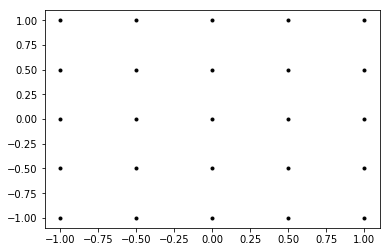

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm

xvalues = np.arange(-1, 1.05, 0.5)
yvalues = np.arange(-1, 1.05, 0.5)

xx, yy = np.meshgrid(xvalues, yvalues)
print(xx)
print()
print(yy)
grid = plt.plot(xx, yy, marker='.', color='k', linestyle='none')

Then, those coordinate grids can be used to calculate values of multivariable functions, or to visualize something beautiful.

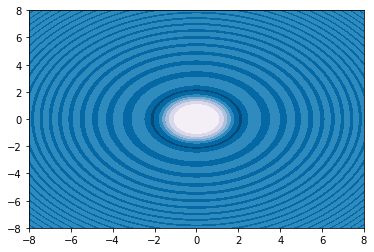

In [5]:
x = np.arange(-8, 8, 0.01)
y = np.arange(-8, 8, 0.01)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)

h = plt.contourf(x,y,z, cmap=cm.PuBu_r)

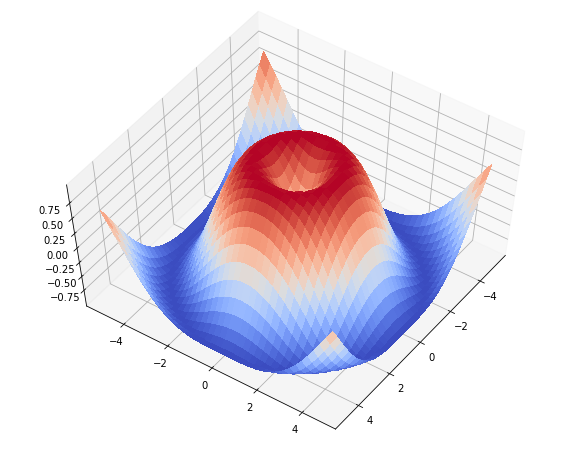

In [111]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d')
ax.view_init(60, 35)

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

### 6. Some interesting samples

And lastly a few examples that shows how NumPy allows to write short and elegant code for computational and ML-related tasks.

#### 6.1 K-Nearest Neighbors

There was a sample above, that counts distances from a single point to set of others. But if it is needed to find the closest points for each point in the set, that can be performed this way:

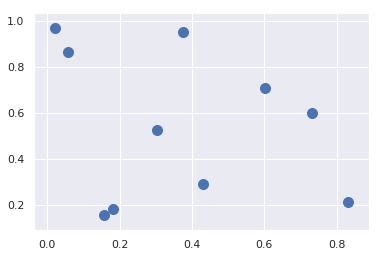

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

rand = np.random.RandomState(42)
X = rand.rand(10, 2)
plt.scatter(X[:, 0], X[:, 1], s=100);

In [14]:
 dist_sq = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=-1)

Here, adding newaxis allows to convert the X matrix with shape (10, 2) into two matrices (10, 1, 2) and (1, 10, 2), that have ten 2D-points in rows and cols correspondingly; then, the broadcasting allows to calculate difference between coordinates of points on the i-th row and j-th column; then square and sum operations give squared euclidean distance between those points. <br>
The dist_qs matrix has zeros on its diagonal, that proves calculation correctness. Distance between ii element is distance between i-th point and itself; that is zero.

In [15]:
dist_sq.diagonal()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Then <i>np.argsort</i> function allows to sort elements in the each row and print indexes of other points in the order of their remoteness from the i-th point:

In [16]:
nearests = np.argsort(dist_sq, axis=1)
print(nearests)

[[0 3 4 5 8 1 9 7 2 6]
 [1 4 6 9 8 0 7 3 2 5]
 [2 7 9 8 6 4 3 1 0 5]
 [3 5 0 8 4 9 7 2 1 6]
 [4 1 0 8 9 6 3 5 7 2]
 [5 3 0 8 4 9 1 7 2 6]
 [6 1 9 4 8 7 2 0 3 5]
 [7 2 9 8 6 4 1 3 0 5]
 [8 9 4 7 2 3 0 1 5 6]
 [9 8 7 2 6 1 4 0 3 5]]


If only K nearest points (unsorted) are needed, the <i>np.argpartition</i> function allows to take them only, without sorting the whole rows: 

In [17]:
K = 2
nearest_partition = np.argpartition(dist_sq, K + 1, axis=1)
print(nearest_partition[:, :K+1])

[[3 0 4]
 [1 4 6]
 [2 7 9]
 [3 5 0]
 [1 4 0]
 [5 3 0]
 [1 9 6]
 [7 2 9]
 [8 9 4]
 [8 7 9]]


That can be visualized:

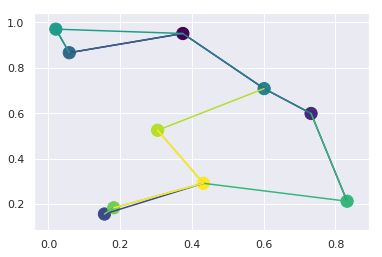

In [18]:
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 10))
plt.scatter(X[:, 0], X[:, 1], s=150, color=colors)

# draw lines from each point to its two nearest neighbors
K = 2

for i in range(X.shape[0]):
    for j in nearest_partition[i, :K+1]:
        # plot a line from X[i] to X[j]
        # the lines colors correspond to outgoing point color, but some lines obviously overlap
        # using some zip magic:
        plt.plot(*zip(X[j], X[i]), c=colors[i])

#### 6.2 Conway's Game of Life

The <a href="https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life" target=__blank>Conway's Game of Life</a> is a classical model of cellular automaton model and a zero-player game. Given an initial state, it starts to live its own life by applying the following rules on each step:<ul>
<li>Each cell on a 2D grid is "alive"(1) or "dead"(0)</li>
<li>Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]</li>
<li>Any cell with exactly 3 neighbors becomes alive (if it was dead)</li></ul>

What it takes to implement this game using NumPy arrays? It's tricky, but not so long:

In [6]:
def iterate(Z):
    # Count neighbours
    N = (Z[0:-2,0:-2] + Z[0:-2,1:-1] + Z[0:-2,2:] +
         Z[1:-1,0:-2]                + Z[1:-1,2:] +
         Z[2:  ,0:-2] + Z[2:  ,1:-1] + Z[2:  ,2:])

    # Apply rules
    birth = (N==3) & (Z[1:-1,1:-1]==0)
    survive = ((N==2) | (N==3)) & (Z[1:-1,1:-1]==1)
    Z[...] = 0
    Z[1:-1,1:-1][birth | survive] = 1
    return Z

<p>First, it slices original matrix with 0, 1 and 2 vertical strides, thus getting matrices with "middle" rows, rows shifted by -1 from the "middle" ones, and rows shifted by +1. The similar action is performed with the columns. Combining this steps in different directions creates 8 shifted matrices; their elementwise sum gives amount of "alive" neighbors for every element of N matrix.</p>
<p>Then, by applying game rules to the N and Z matrices the boolean mask matrices "birth" and "survive" can be calculated. After that, NumPy boolean indexing allows to set to "1" only those cells that were born or had survived.</p>

The folowing code allows to animate the game process when running the notebook. Hopping, nbviewer will show at least a resulting picture :)

<IPython.core.display.Javascript object>


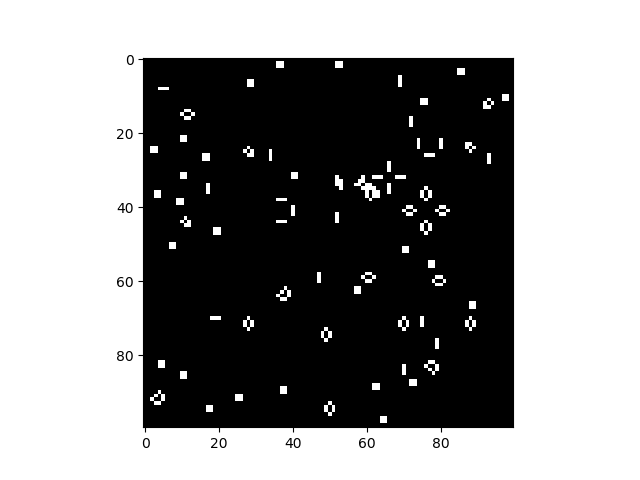

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
plt.ion()

#initialize game field
Z = np.random.choice([0,1],size=(100,100))

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(1000):    
    #update
    Z = iterate(Z)
    
    #re-draw image
    ax.clear()
    ax.imshow(Z,cmap='gray')
    fig.canvas.draw()

#### 6.3 Convolutional layers in Convolutional Neural Networks

The topic above is quite close to the ML area, as the action performed there is similar to the principle of convolutional layers in Convolution Neural Networks (CNN).<br>
When convolution is applied, for example to an image in computer vision, it takes the matrix with image pixels and  slides across it with small window called "filter" or "kernel". The kernel is just little (3x3, 5x5, 7x7 or smth. like this) weight matrix that contains numerical coefficients. Each of these coefficients has to be multiplied by the value of pixel that is currently under the corresponding kernel cell. Then, all such multiplied element are summed, giving the value of an element of the resulting map. After that, the kernel is moved by 1 or more strides horizontaly or verticaly, to the next group of pixels, and the next weighted sum is calculated.<br>
This image illustrates the process of applying the filter and calculating an element of resulting map:

<center>
<img src="../../img/kseniia_convolution.png" style="width: 600px;" />

In fact, the N matrix, calculating amount of cell's neighbors is similar convolution result, using a filter with wieght "0" for the middle element and "1" for all its neighbors.<br>

In [9]:
filters = np.array([[1,1,1],
                    [1,0,1],
                    [1,1,1]])

Neural networks usually offers such operation as a ready functionality (<a href="https://pytorch.org/docs/master/nn.html#torch-nn-functional" target=__blank>Pytorch for example</a>). And even scipy model has such a <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html" target=__blank>function</a>. <br>
Let's see if it indeed does the same thing:

In [22]:
from scipy import signal

Z = np.random.choice([0,1],size=(10,10))

N1 = (Z[0:-2,0:-2] + Z[0:-2,1:-1] + Z[0:-2,2:] +
      Z[1:-1,0:-2]                + Z[1:-1,2:] +
      Z[2:  ,0:-2] + Z[2:  ,1:-1] + Z[2:  ,2:]) 

N2 = signal.convolve2d(Z, filters, mode='valid')

print("Are N1 and N2 identical?")
print(np.array_equal(N1, N2))

Are N1 and N2 identical?
True


That's all by this moment. Hopping, it was informative :)

## References
<ol>
    <li><a href="http://shop.oreilly.com/product/0636920034919.do" target=__blank>"Python Data Science Handbook"</a> by Jake VanderPlas</li><ul><li><a href="https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/" target=__blank>"Why Python is slow"</a> article</li>
        <li><a href="https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html" target=__blanl>Computation on Arrays: Broadcasting</a></li>
    <li><a href="https://jakevdp.github.io/PythonDataScienceHandbook/02.08-sorting.html#Example:-k-Nearest-Neighbors" target=__blank>K-Nearest Neighbors sample</a></li>
    </ul>
    <li><a href="https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae">What is numpy.newaxis and when to use it</a></li>
    <li>NumPy documentation about <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html" target=__blank>numpy.dot</a>, <a href="https://docs.scipy.org/doc/numpy/reference/constants.html#numpy.newaxis" target=__blank>numpy.newaxis</a>, <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html" target=__blank>numpy.meshgrid</a></li>
    <li><a href="https://matplotlib.org/examples/mplot3d/surface3d_demo.html">Matplotlib 3d surface example</a></li>
    <li>Exercise 88 from the <a href="https://github.com/rougier/numpy-100/blob/master/100_Numpy_exercises.ipynb">100 NumPy exercises</a></li>
<ol>